<a href="https://colab.research.google.com/github/BerserkerD81/integracion-de-datos-tarea-1/blob/main/tarea1_jorgeMigueles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taller Integrado de Ciencia de Datos — Unidad 1
## Producto Computacional: Exploración inicial del dataset **MHEALTH**

> **Fecha:** 2025-09-04  
> **Autor:** *Jorge Migueles*

---

### Objetivo
Realizar las primeras etapas del ciclo de vida de un proyecto de ciencias de datos : **carga, exploración, limpieza y preprocesamiento inicial**.

### Dataset
**MHEALTH (Mobile Health Dataset for Activity Recognition)**. Registra señales fisiológicas y de sensores (acelerómetros, giroscopios, ECG, etc.) durante actividades humanas.
---


## Índice
1. [Preparación del entorno](#prep)
2. [Obtención del dataset](#get)
3. [Carga y estructura de los datos](#load)
4. [Exploración inicial](#eda)
5. [Visualizaciones](#viz)
6. [Limpieza y preprocesamiento](#prepoc)
7. [Referencias](#refs)


## 1) Preparación del entorno <a id="prep"></a>

Instalamos/Importamos librerías necesarias.


In [1]:
# !pip install numpy pandas matplotlib scikit-learn scipy

import os, io, zipfile, glob, textwrap, itertools, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

plt.rcParams["figure.figsize"] = (9, 4)
pd.set_option("display.max_columns", 50)

print("Versions -> numpy:", np.__version__, "| pandas:", pd.__version__)

Versions -> numpy: 2.0.2 | pandas: 2.2.2


## 2) Obtención del dataset <a id="get"></a>

Intentaremos descargar el dataset desde el repositorio de UCI. Si la descarga falla se puede usar **insertando manualmente** el archivo `MHEALTHDATASET.zip` a la sesión y ejecutar la celda nuevamente.

- Ruta esperada tras extraer: `./MHEALTHDATASET/`
- Archivos: `mHealth_subject1.log`, `mHealth_subject2.log`, ...


In [2]:
import requests

UCI_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00319/MHEALTHDATASET.zip"
local_zip = "MHEALTHDATASET.zip"
target_dir = "MHEALTHDATASET"

# Verifica si el dataset ya está descargado
def have_dataset():
    return os.path.isdir(target_dir) and len(glob.glob(os.path.join(target_dir, "*.log"))) > 0

# Descargar y extraer si no está presente
if not have_dataset():
    try:
        print("Descargando desde UCI...")
        r = requests.get(UCI_URL, timeout=60)
        r.raise_for_status()
        with open(local_zip, "wb") as f:
            f.write(r.content)
        with zipfile.ZipFile(local_zip, "r") as zf:
            zf.extractall(".")
        print("Descarga y extracción completadas.")
    except Exception as e:
        print("No se pudo descargar automáticamente:", e)
else:
    print("Dataset ya presente en el directorio.")

Descargando desde UCI...
Descarga y extracción completadas.


## 3) Carga y estructura de los datos <a id="load"></a>

Los archivos `.log` se concatenan añadiendo un identificador de sujeto (`subject`). El dataset no incluye encabezados;
por ello, **inferimos** el número de columnas y asignamos nombres genéricos o, si coincide con el esquema esperado,
usamos nombres informativos de sensores.


In [3]:
assert os.path.isdir("MHEALTHDATASET"), "No se encontró la carpeta 'MHEALTHDATASET'. Verifica la sección anterior."

files = sorted(glob.glob("MHEALTHDATASET/*.log"))
assert files, "No se encontraron archivos .log dentro de MHEALTHDATASET"

# Detectar columnas leyendo pequeñas muestras
sample = pd.read_csv(files[0], sep=r'\s+', header=None, nrows=5)
n_cols = sample.shape[1]
print(f"Detectadas {n_cols} columnas en los archivos .log")

# Esquema conocido (23 señales + 1 etiqueta = 24 columnas)
schema_24 = [
    "acc_chest_x","acc_chest_y","acc_chest_z",
    "ecg_1","ecg_2",
    "acc_ankle_x","acc_ankle_y","acc_ankle_z",
    "gyro_ankle_x","gyro_ankle_y","gyro_ankle_z",
    "mag_ankle_x","mag_ankle_y","mag_ankle_z",
    "acc_arm_x","acc_arm_y","acc_arm_z",
    "gyro_arm_x","gyro_arm_y","gyro_arm_z",
    "mag_arm_x","mag_arm_y","mag_arm_z",
    "label"
]

if n_cols == 24:
    colnames = schema_24
else:
    # Nombres genéricos: f1..fn-1 + label (última col)
    colnames = [f"f{i}" for i in range(1, n_cols)]
    colnames.append("label")

def load_one(path, subject_id):
    df = pd.read_csv(path, sep=r'\s+', header=None, names=colnames)
    df["subject"] = subject_id
    return df

frames = []
for i, path in enumerate(files, start=1):
    frames.append(load_one(path, subject_id=i))

data = pd.concat(frames, ignore_index=True)
print("Dimensiones del dataset concatenado:", data.shape)
display(data.head())

# Asegurar tipos
for c in data.columns:
    if c not in ("label", "subject"):
        data[c] = pd.to_numeric(data[c], errors="coerce")

data["label"] = pd.to_numeric(data["label"], errors="coerce").astype("Int64")
data["subject"] = pd.to_numeric(data["subject"], errors="coerce").astype("Int64")

Detectadas 24 columnas en los archivos .log
Dimensiones del dataset concatenado: (1215745, 25)


,acc_chest_x,acc_chest_y,acc_chest_z,ecg_1,ecg_2,acc_ankle_x,acc_ankle_y,acc_ankle_z,gyro_ankle_x,gyro_ankle_y,gyro_ankle_z,mag_ankle_x,mag_ankle_y,mag_ankle_z,acc_arm_x,acc_arm_y,acc_arm_z,gyro_arm_x,gyro_arm_y,gyro_arm_z,mag_arm_x,mag_arm_y,mag_arm_z,label,subject
0,-9.8184,0.009971,0.29563,0.004186,0.004186,2.1849,-9.6967,0.63077,0.103900,-0.84053,-0.68762,-0.370000,-0.36327,0.29963,-8.6499,-4.5781,0.187760,-0.44902,-1.0103,0.034483,-2.35000,-1.610200,-0.030899,0,1
1,-9.8489,0.524040,0.37348,0.004186,0.016745,2.3876,-9.5080,0.68389,0.085343,-0.83865,-0.68369,-0.197990,-0.18151,0.58298,-8.6275,-4.3198,0.023595,-0.44902,-1.0103,0.034483,-2.16320,-0.882540,0.326570,0,1
2,-9.6602,0.181850,0.43742,0.016745,0.037677,2.4086,-9.5674,0.68113,0.085343,-0.83865,-0.68369,-0.374170,0.18723,0.43851,-8.5055,-4.2772,0.275720,-0.44902,-1.0103,0.034483,-1.61750,-0.165620,-0.030693,0,1
3,-9.6507,0.214220,0.24033,0.079540,0.117220,2.1814,-9.4301,0.55031,0.085343,-0.83865,-0.68369,-0.017271,0.18366,0.57571,-8.6279,-4.3163,0.367520,-0.45686,-1.0082,0.025862,-1.07710,0.006945,-0.382620,0,1
4,-9.7030,0.303890,0.31156,0.221870,0.205130,2.4173,-9.3889,0.71098,0.085343,-0.83865,-0.68369,-0.374390,-0.54671,0.44586,-8.7008,-4.1459,0.407290,-0.45686,-1.0082,0.025862,-0.53684,0.175900,-1.095500,0,1


## 4) Exploración inicial <a id="eda"></a>

Revision de las dimensiones, tipos de variables, valores faltantes etc.

In [4]:
print("Filas, Columnas:", data.shape)
print("\nTipos de datos:")
print(data.dtypes)

# Valores faltantes
na_counts = data.isna().sum()
print("\nValores faltantes por columna (top 10):")
print(na_counts.sort_values(ascending=False).head(10))

# Estadísticas básicas (solo numéricas)
desc = data.describe().T
display(desc.head(10))

# Distribución de etiquetas
label_counts = data["label"].value_counts(dropna=False).sort_index()
print("\nDistribución de la variable 'label':")
print(label_counts)

# Guardar tablas útiles en CSV
desc.to_csv("stats_descriptivas.csv")
label_counts.to_csv("distribucion_labels.csv")

Filas, Columnas: (1215745, 25)

Tipos de datos:
acc_chest_x     float64
acc_chest_y     float64
acc_chest_z     float64
ecg_1           float64
ecg_2           float64
acc_ankle_x     float64
acc_ankle_y     float64
acc_ankle_z     float64
gyro_ankle_x    float64
gyro_ankle_y    float64
gyro_ankle_z    float64
mag_ankle_x     float64
mag_ankle_y     float64
mag_ankle_z     float64
acc_arm_x       float64
acc_arm_y       float64
acc_arm_z       float64
gyro_arm_x      float64
gyro_arm_y      float64
gyro_arm_z      float64
mag_arm_x       float64
mag_arm_y       float64
mag_arm_z       float64
label             Int64
subject           Int64
dtype: object

Valores faltantes por columna (top 10):
acc_chest_x     0
acc_chest_y     0
acc_chest_z     0
ecg_1           0
ecg_2           0
acc_ankle_x     0
acc_ankle_y     0
acc_ankle_z     0
gyro_ankle_x    0
gyro_ankle_y    0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
acc_chest_x,1215745.0,-8.522361,4.075293,-22.438,-9.804,-9.3114,-7.6371,19.094
acc_chest_y,1215745.0,-0.214001,2.138954,-20.188,-1.2729,-0.35381,0.70978,20.927
acc_chest_z,1215745.0,-1.05595,3.574163,-18.401,-2.8673,-0.8702,0.72591,26.196
ecg_1,1215745.0,-0.005122,0.746597,-8.6196,-0.23443,-0.071167,0.15908,8.5149
ecg_2,1215745.0,-0.004506,0.72704,-8.6196,-0.18838,-0.041863,0.15071,8.5191
acc_ankle_x,1215745.0,1.4942,3.826485,-22.146,0.14131,1.3089,2.5758,20.054
acc_ankle_y,1215745.0,-9.692878,4.171303,-19.619,-10.201,-9.6703,-9.0422,21.161
acc_ankle_z,1215745.0,-0.954806,5.461803,-19.373,-2.6494,-0.016456,1.3013,25.015
gyro_ankle_x,1215745.0,-0.001599,0.491217,-2.1466,-0.43599,-0.014842,0.44898,60.484
gyro_ankle_y,1215745.0,-0.616632,0.354641,-7.7899,-0.81801,-0.70732,-0.54034,2.0113



Distribución de la variable 'label':
label
0     872550
1      30720
2      30720
3      30720
4      30720
5      30720
6      28315
7      29441
8      29337
9      30720
10     30720
11     30720
12     10342
Name: count, dtype: Int64


**Reflexión:**  
- Este dataset es uno de tipo multivariante continuas por tiempo. La muestra combinada por sujetos no es independiente e idénticamente distribuida.
- En esta etapa al ser una inicial el enfoque es en comprender rangos, escalas y balance de clases (etiquetas).

## 5) Visualizaciones <a id="viz"></a>
Primero reviso las **series temporales** de varias señales para identificar patrones iniciales.  
Después observo las **distribuciones** mediante histogramas y boxplots para detectar **datos atípicos**.  
También reviso la **frecuencia de las etiquetas** y finalmente la **matriz de correlación**, para identificar relaciones entre variables.


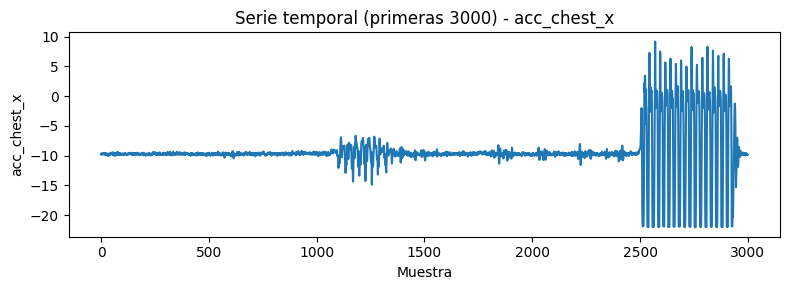

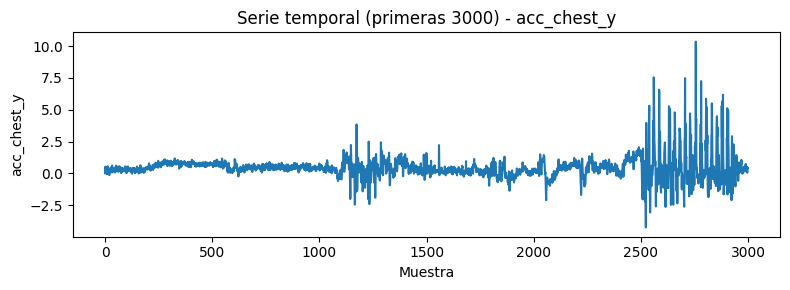

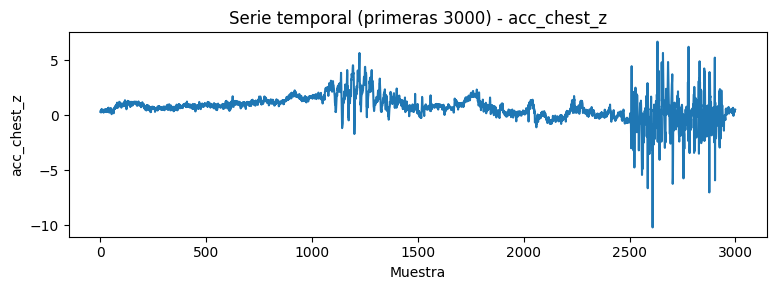

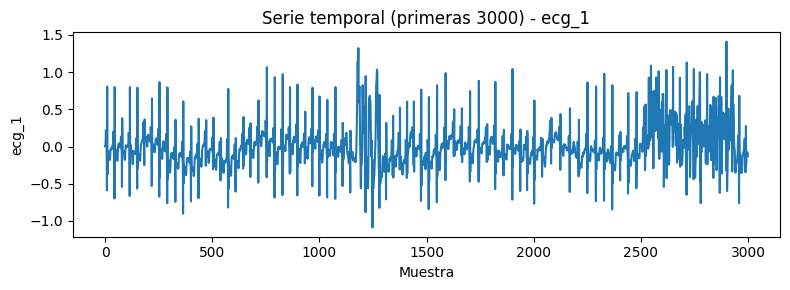

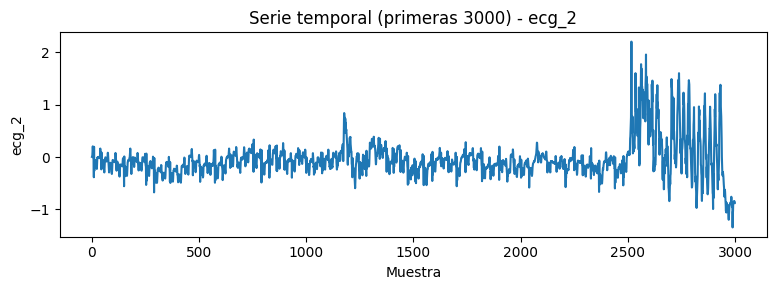

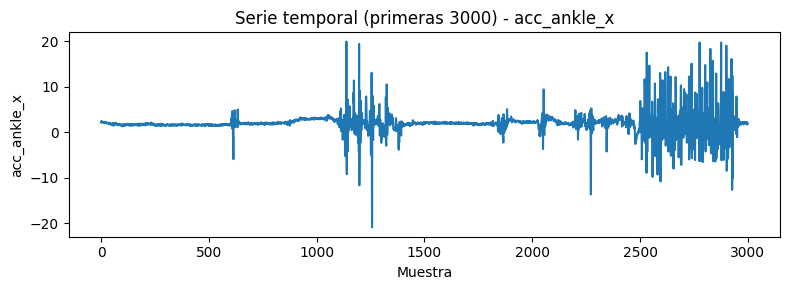

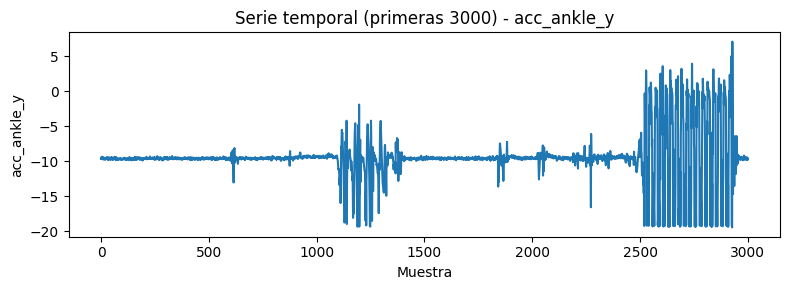

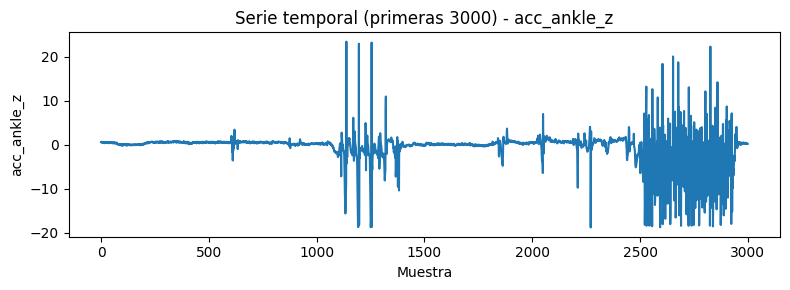

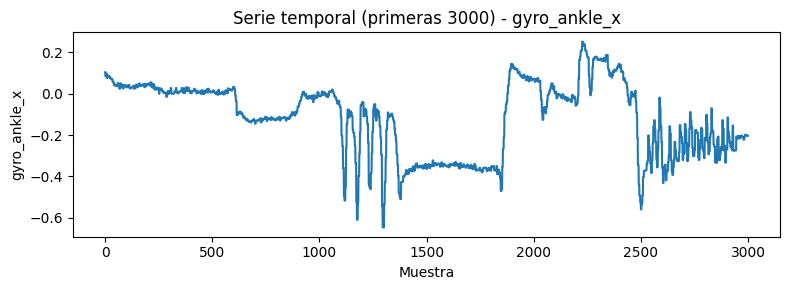

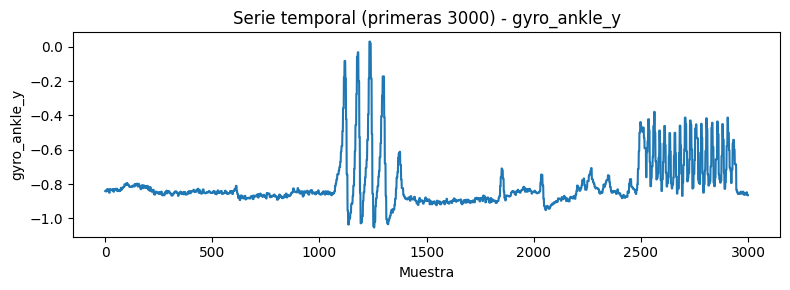

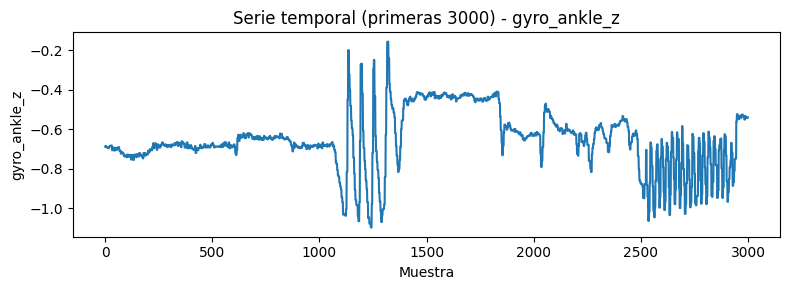

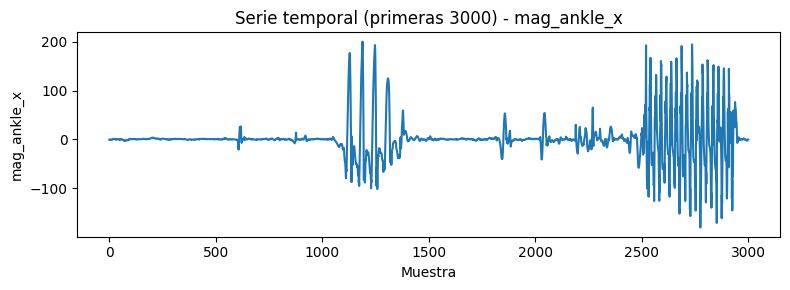

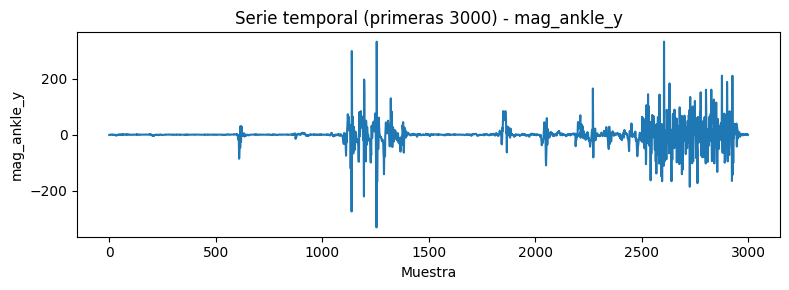

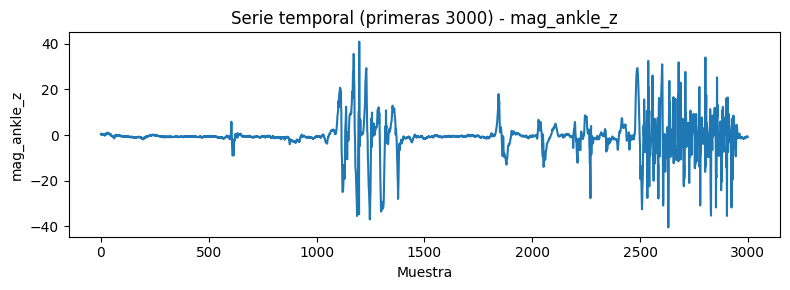

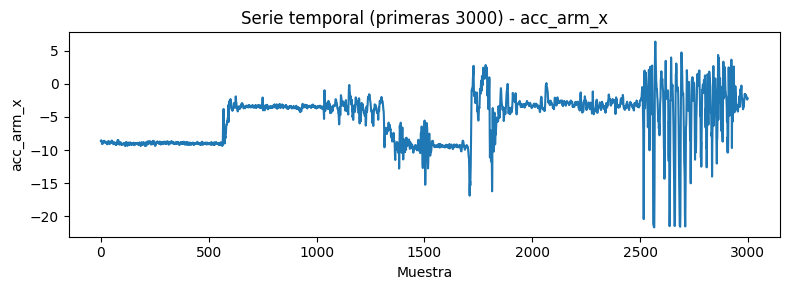

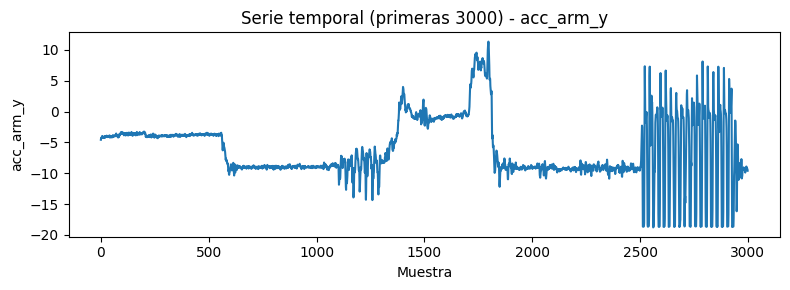

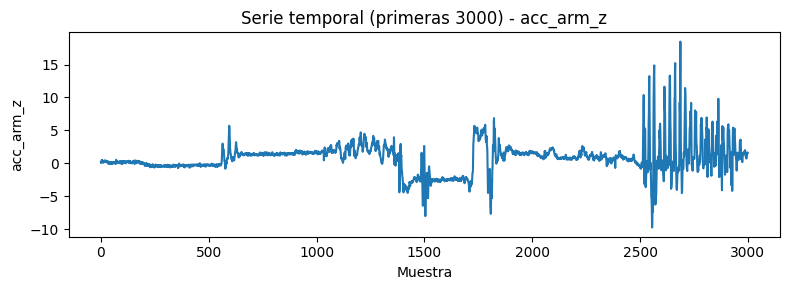

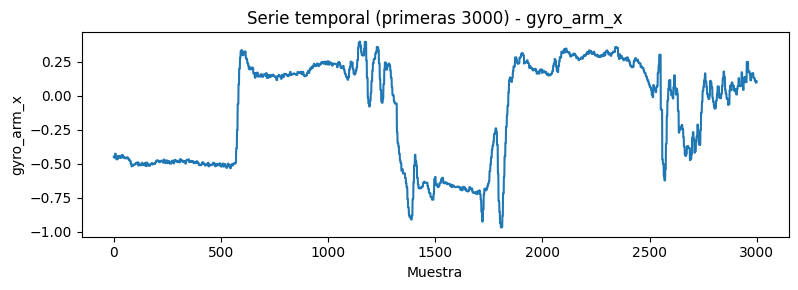

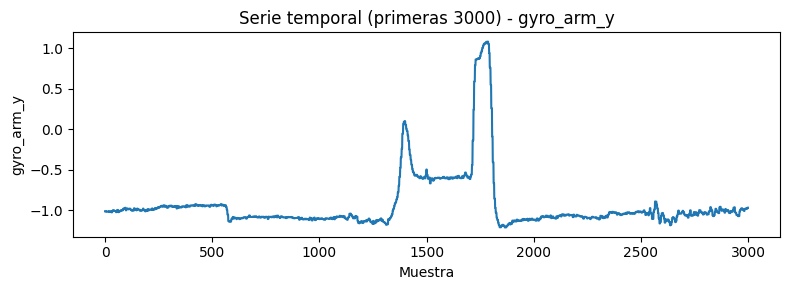

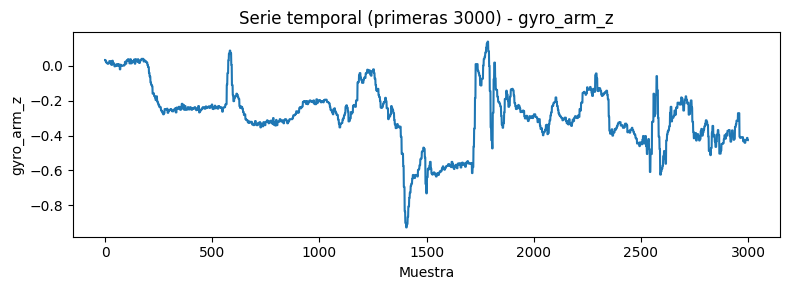

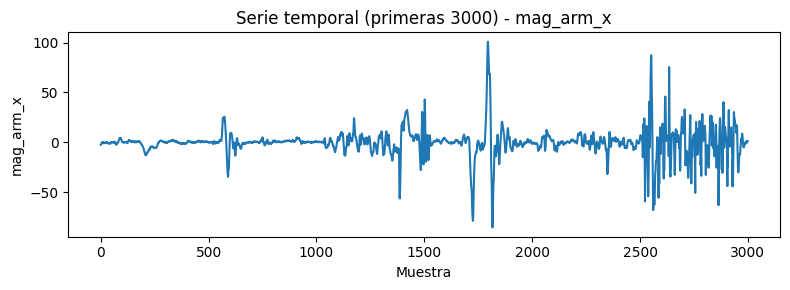

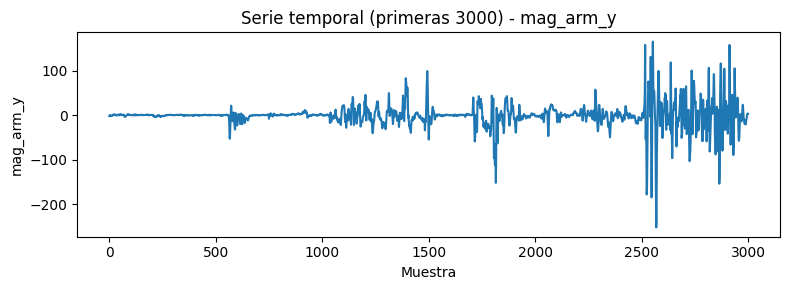

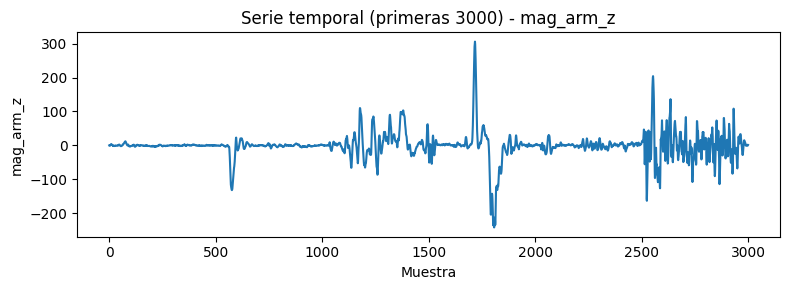

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionar todas las señales numéricas
candidates = [c for c in data.columns if c not in ("label","subject")]

# 5.1 Series temporales (primeras 3000 muestras)
subset = data.head(3000)
for col in candidates:
    plt.figure(figsize=(8,3))
    plt.plot(subset[col].values)
    plt.title(f"Serie temporal (primeras 3000) - {col}")
    plt.xlabel("Muestra")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

# 5.2 Histogramas y Boxplots para TODAS las variables numéricas
for col in candidates:
    fig, axes = plt.subplots(1,2, figsize=(10,3))

    # Histograma
    sns.histplot(data[col].dropna(), bins=50, ax=axes[0], kde=True)
    axes[0].set_title(f"Histograma de {col}")

    # Boxplot
    sns.boxplot(x=data[col].dropna(), ax=axes[1])
    axes[1].set_title(f"Boxplot de {col} (outliers)")

    plt.tight_layout()
    plt.show()

# 5.3 Frecuencia de etiquetas
plt.figure(figsize=(6,4))
label_counts = data["label"].value_counts().sort_index()
sns.barplot(x=label_counts.index.astype(str), y=label_counts.values)
plt.title("Frecuencia de etiquetas")
plt.xlabel("Etiqueta")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# 5.4 Matriz de correlación (todas las variables numéricas)
if candidates:
    corr = data[candidates].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, cmap="coolwarm", annot=False,
                xticklabels=candidates, yticklabels=candidates)
    plt.title("Matriz de correlación")
    plt.tight_layout()
    plt.show()


**Reflexión:**  
- Las series temporales muestran patrones repetitivos y ruido, comunes en sensores corporales.  
- La distribución de etiquetas permite detectar **desbalance de clases**, relevante para futuros modelos.  
- Mediante los histogramas y boxplots, se pueden apreciar valores atípicos. Reconocer estos outliers es fundamental para decidir si debo filtrarlos o tratarlos antes de entrenar cualquier modelo.
- La correlación entre variables cercanas (p.ej., ejes de un mismo sensor) puede ser alta; esto sugiere considerar técnicas de reducción de dimensionalidad más adelante.

## 6) Limpieza y preprocesamiento <a id="prepoc"></a>

Objetivos aquí:
- **Faltantes**: cuantificar y, si corresponde, imputar.
- **Atípicos**: detectar con **rango intercuartílico (IQR)** y aplicar *capping* ligero (winsorización) cuando tenga sentido.
- **Escalado**: estandarizar variables continuas para facilitar futuros modelos.

> *Criterios de decisión*:  
> - Si no hay faltantes, no imputamos.  
> - Si el porcentaje de atípicos por variable > 5%, aplicamos capping al percentil 1 y 99 (o límites IQR).  
> - Estandarizamos con `StandardScaler` sólo las columnas de señales (dejando `label` y `subject` intactas).


In [ ]:
signals = [c for c in data.columns if c not in ("label","subject")]
X = data[signals].copy()

# 6.1 Faltantes
na_ratio = X.isna().mean().sort_values(ascending=False)
print("Porcentaje de faltantes (top 10):")
print((na_ratio.head(10) * 100).round(3).astype(str) + "%")

# Imputación (si corresponde)
if (na_ratio > 0).any():
    print("Imputando faltantes con mediana...")
    imputer = SimpleImputer(strategy="median")
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=signals)
else:
    print("No se encontraron faltantes; se copia X tal cual.")
    X_imputed = X

# 6.2 Atípicos con IQR + capping
def iqr_caps(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    low = q1 - k * iqr
    high = q3 + k * iqr
    capped = series.clip(lower=low, upper=high)
    return capped, (low, high)

caps = {}
X_capped = X_imputed.copy()
for col in signals:
    capped, bounds = iqr_caps(X_imputed[col])
    X_capped[col] = capped
    caps[col] = bounds

# Medimos cuántos valores fueron cappeados
def percent_capped(original, capped):
    return (original.ne(capped)).mean() * 100

capped_pct = {col: percent_capped(X_imputed[col], X_capped[col]) for col in signals}
capped_summary = pd.Series(capped_pct).sort_values(ascending=False)
print("\n% de valores cappeados por columna (top 10):")
print(capped_summary.head(10).round(3).astype(str) + "%")

# 6.3 Estandarización
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_capped), columns=signals)

# 6.4 Reconstruimos el dataset limpio
clean = pd.concat([X_scaled, data[["label","subject"]].reset_index(drop=True)], axis=1)

print("\nDimensiones del dataset limpio:", clean.shape)
display(clean.head())

# Guardamos artefactos
clean.to_csv("mhealth_clean_sample.csv", index=False)
pd.Series(caps).to_csv("capping_bounds.csv")

**Justificación de decisiones**  
- **Imputación**: elegimos la mediana por robustez ante asimetrías. Si no hay faltantes, evitamos transformaciones innecesarias.  
- **Atípicos (IQR)**: en señales fisiológicas los extremos pueden ser ruido o picos por movimiento; el *capping* suave reduce su impacto sin eliminar información.  
- **Estandarización**: centra y escala variables para que todas contribuyan de forma comparable a futuros modelos (p.ej., PCA o clasificadores lineales).

## 7) Referencias <a id="refs"></a>

[1] O. Banos et al., “mHealthDroid: A Novel Framework for Agile Development of Mobile Health Applications,” *Ambient Assisted Living and Daily Activities*, LNCS 8868, Springer, 2014.  
[2] J. Miah et al., “MHfit: Mobile Health Data for Predicting Athletics Fitness Using Machine Learning,” arXiv:2304.04839, 2023.

> **Nota**: para consultar el *data sheet* oficial del dataset, revisa el repositorio UCI MLR correspondiente a **MHEALTH**.
